In [2]:
import scipy.io as scio
import h5py
import tifffile as tf
from PIL import Image

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import pearsonr
import networkx as nx
from networkx.algorithms import community
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import itertools
from itertools import chain

## Settings and Parameters

In [3]:
## parameters
data_index = 'xxxx' # for example '20230429-r5HT1.0-fly1'
date_id = 'xxxx' # for example '20230429'
fly_id = 'xxxx' # for example 'fly1'
n_trails = 1

data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # all brain regions
focus_regions_1 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,85,67] # brain regions except 82
focus_regions_2 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,85,67] # brain regions except 80, 82
focus_regions_3 = [64,65,66,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67] # brain regions except 55

## path
path = 'xxxx/nsyb-G7f-r5HT1.0/'+ date_id + '-nsyb-G7f-r5HT1.0/'+ fly_id + '/data/'
path_atlas  = 'xxxx/data/5HT/'+ data_index + '/align_to_atlas/'
path_output = '../result/flies_5HT/'+ data_index + '-pre_stimu/'

## Load data

In [7]:
'''
Load G7f data

Data description: dff0_start_long_c2 is 807 timepoints * 25 * 256 * 256 (z,x,y)
'''

dff0_con_C2 = np.load(path + 'dff0_start_long_c2.npy')

print(type(dff0_con_C2), dff0_con_C2.shape)

<class 'numpy.ndarray'> (404, 25, 256, 256)


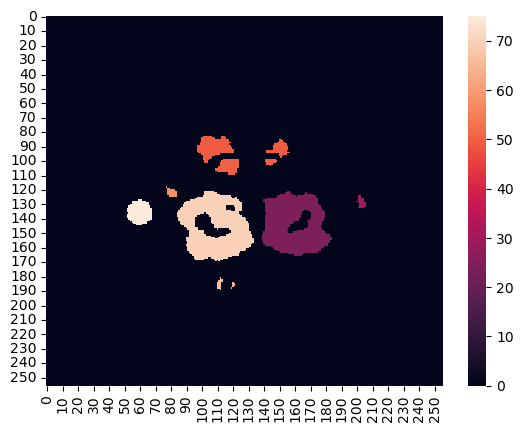

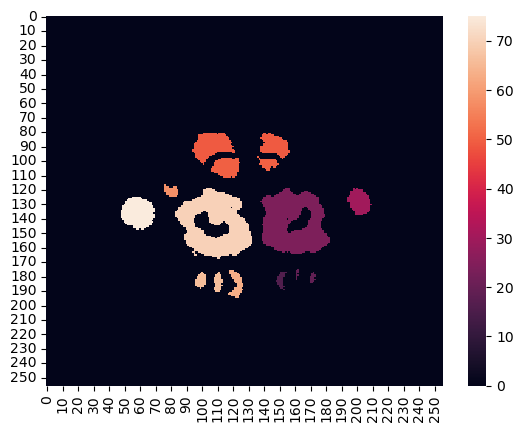

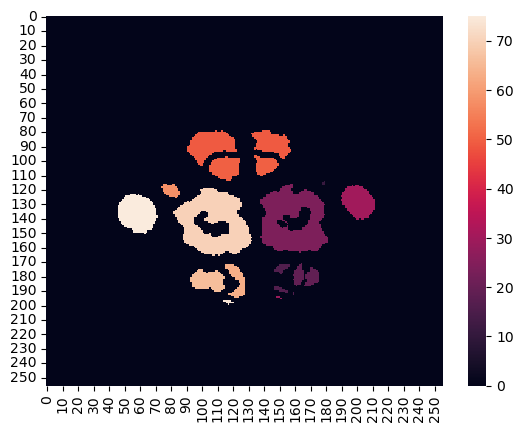

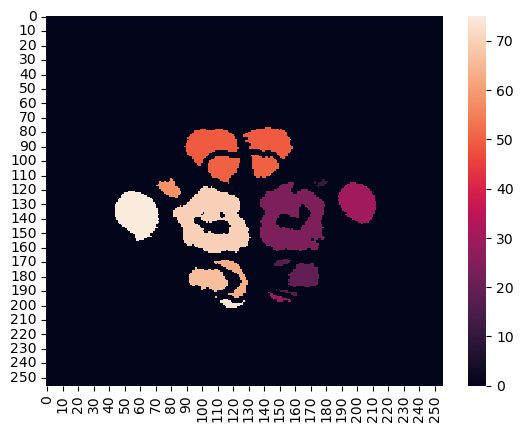

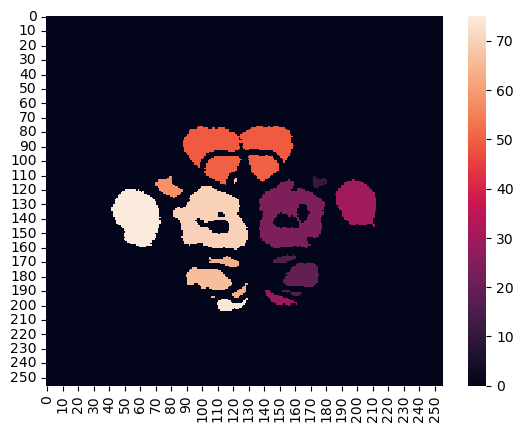

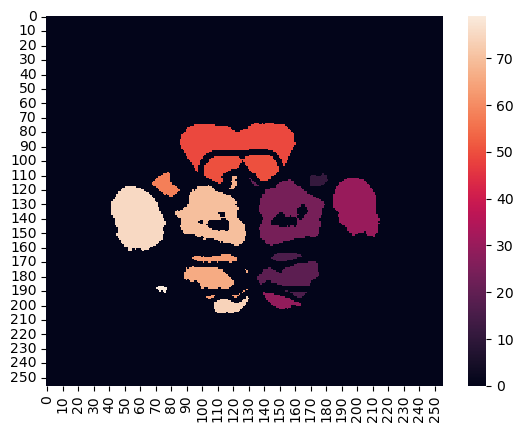

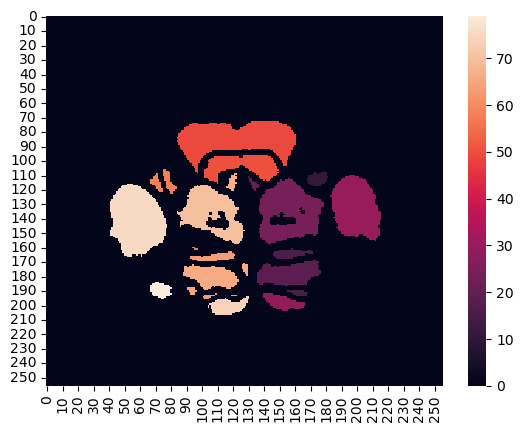

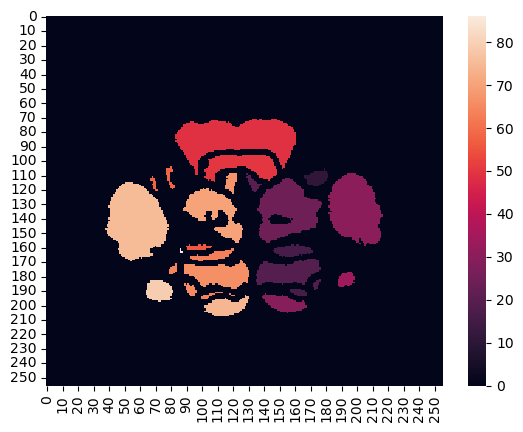

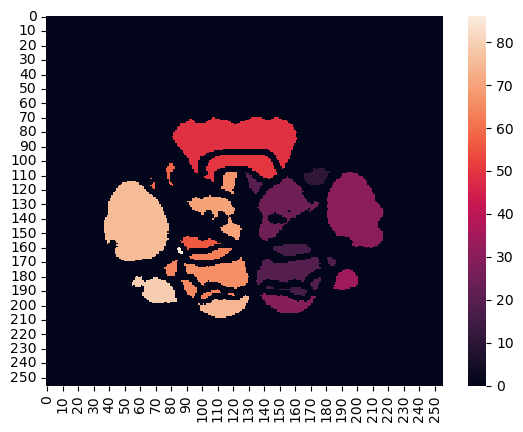

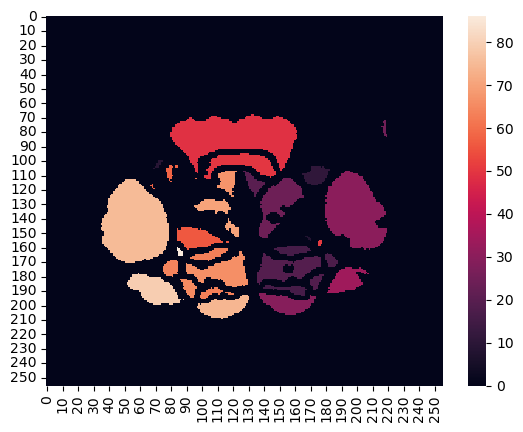

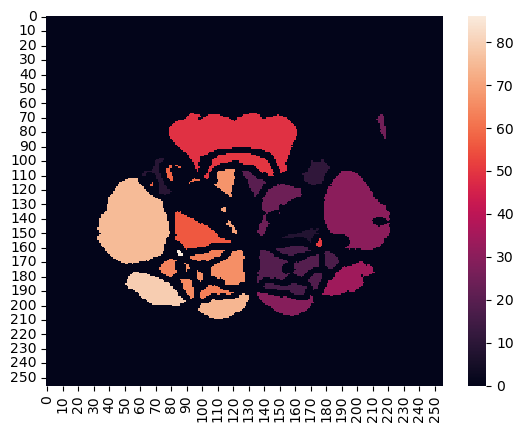

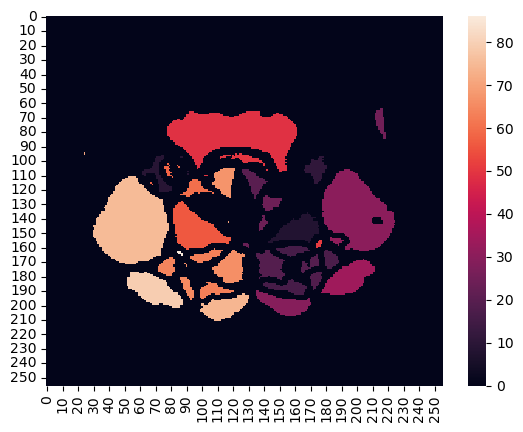

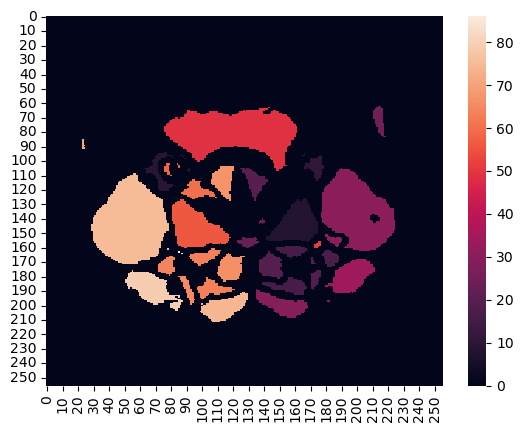

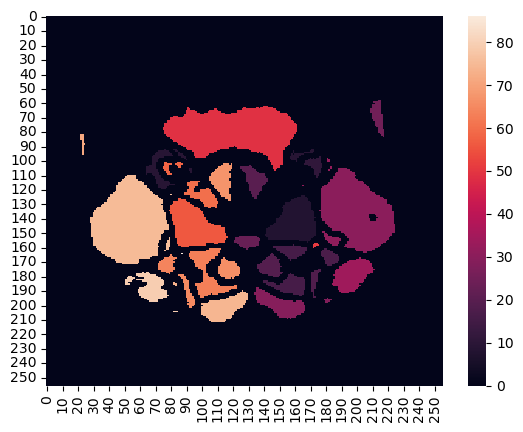

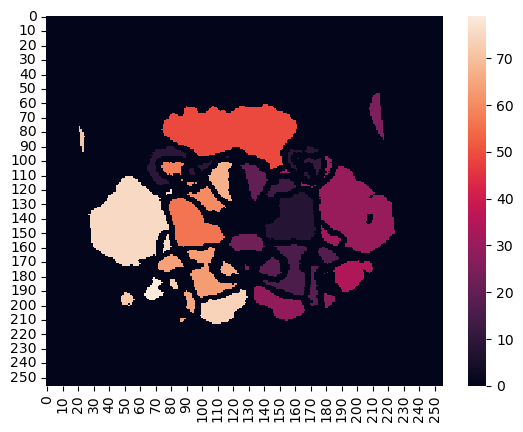

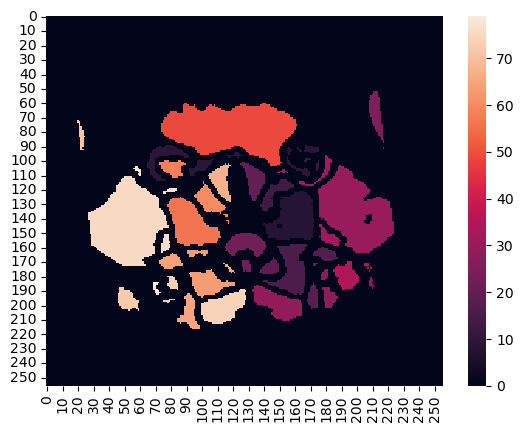

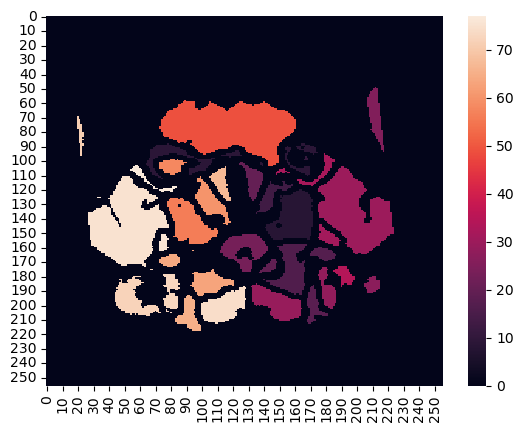

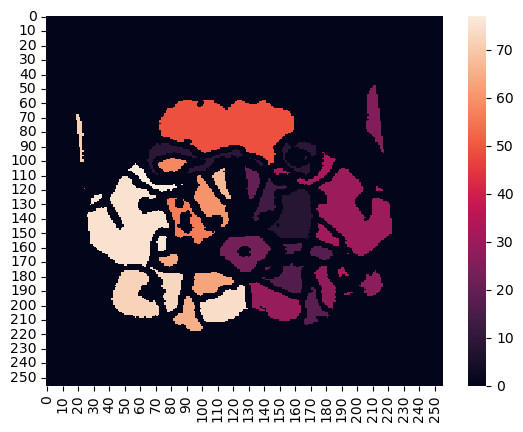

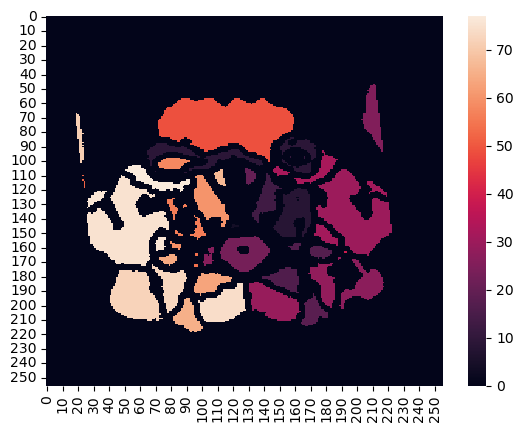

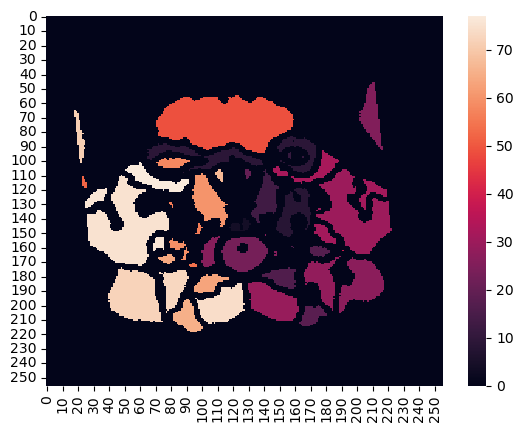

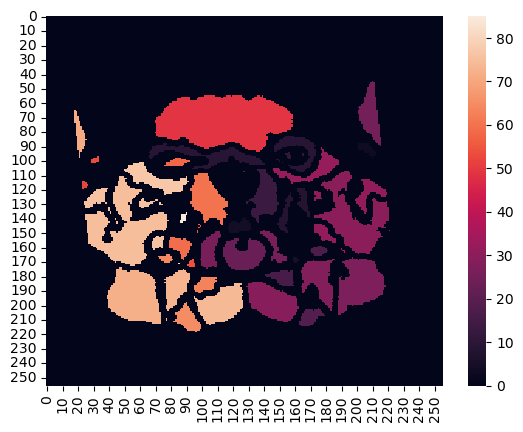

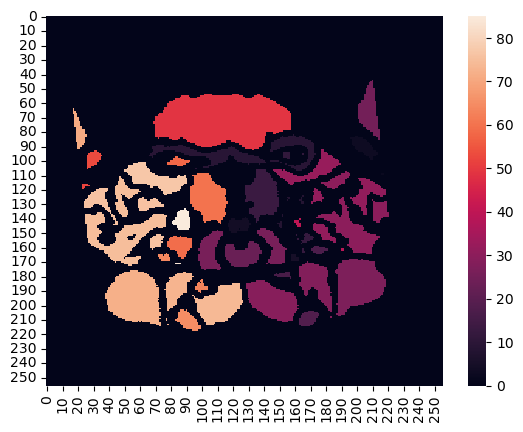

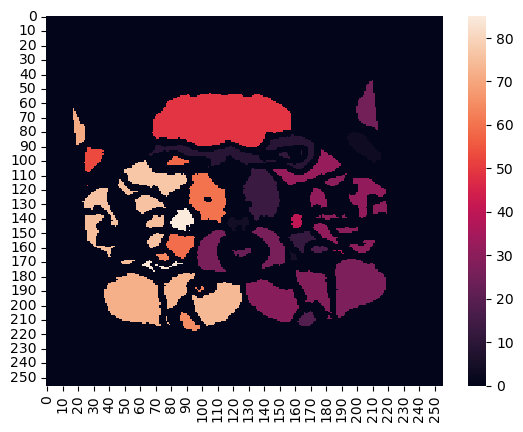

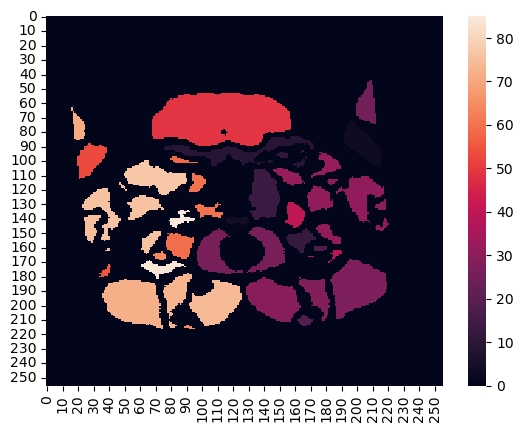

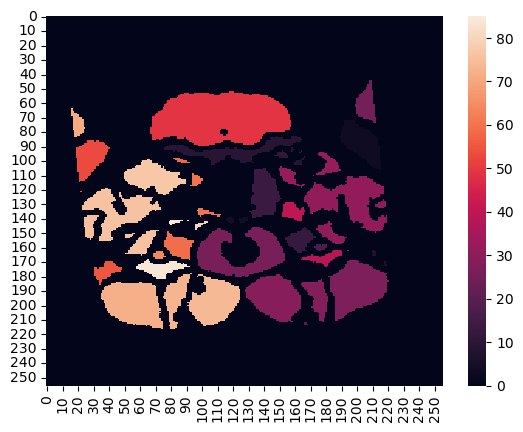

# region indices:  57  region indices:  [2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 39, 40, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 84, 85, 86]


In [8]:
'''
Load atlas 
'''

## load atlas data
image_file = path_atlas + 'Transformed_atlas_eroded_r5.tif'
img_tf = tf.imread(image_file)

## list the brain region indices
region_idx = []
for i in range(13,38): # only need the 13th - 38th layers of atlas
    non_val = img_tf[i].ravel()[np.flatnonzero(img_tf[i])].tolist()
    region_idx += list(set(non_val))
    ## plot atlas
    data = pd.DataFrame(img_tf[i])
    sns.heatmap(data)
    plt.show()
region_idx = list(set(region_idx))

print("# region indices: ", len(region_idx), " region indices: ", region_idx)

## Concatenate G7f recordings

In [5]:
## Splicing multiple sessions for each neuron
for region_idx in focus_regions_0:
    ## save the neuron positions of each region
    neurons_positions = {}    
    for i in range(13,38):
        x_idx, y_idx = np.where(img_tf[i] == region_idx)
        if len(x_idx) > 0 and len(y_idx) > 0:
            neurons_positions[i] = [(x_idx[j], y_idx[j]) for j in range(len(x_idx))]
    np.save(path_output + 'region_' + str(region_idx) + '_neuron_positions.npy', neurons_positions)
    print('region_' + str(region_idx) + ' save neuron positions!')
    
    ## save the neuron G7f records of each region
    neuron_records = []
    for k,v in neurons_positions.items():
        z = k - 13
        for x_y in v:
            neuron_record = list(dff0_con_C2[:, z, x_y[0], x_y[1]])  
            neuron_records.append(neuron_record)
    np.save(path_output + 'region_' + str(region_idx) + '_neuron_records.npy', neuron_records)
    if len(neuron_records) == 0:
        print('neuron records: ', 0, 0)
    else:
        print('neuron records: ', len(neuron_records),len(neuron_records[0]))
    
    del neuron_records 
    del neurons_positions

print('END')

region_64 save neuron positions!
neuron records:  891 807
region_65 save neuron positions!
neuron records:  1213 807
region_66 save neuron positions!
neuron records:  2680 807
region_55 save neuron positions!
neuron records:  3354 807
region_72 save neuron positions!
neuron records:  10426 807
region_73 save neuron positions!
neuron records:  2065 807
region_74 save neuron positions!
neuron records:  10327 807
region_63 save neuron positions!
neuron records:  2648 807
region_84 save neuron positions!
neuron records:  2233 807
region_59 save neuron positions!
neuron records:  2442 807
region_4 save neuron positions!
neuron records:  304 807
region_23 save neuron positions!
neuron records:  2120 807
region_26 save neuron positions!
neuron records:  7518 807
region_56 save neuron positions!
neuron records:  3401 807
region_79 save neuron positions!
neuron records:  1840 807
region_75 save neuron positions!
neuron records:  19670 807
region_76 save neuron positions!
neuron records:  4167 8

## Generate the brain-region-level functional connectivity network

---- processing region  64  ----
G7f data: 1248 404
selected data: 1248 396
---- processing region  65  ----
G7f data: 2089 404
selected data: 2089 396
---- processing region  66  ----
G7f data: 4523 404
selected data: 4523 396
---- processing region  55  ----
G7f data: 172 404
selected data: 172 396
---- processing region  72  ----
G7f data: 8010 404
selected data: 8010 396
---- processing region  73  ----
G7f data: 2618 404
selected data: 2618 396
---- processing region  74  ----
G7f data: 8893 404
selected data: 8893 396
---- processing region  63  ----
G7f data: 4346 404
selected data: 4346 396
---- processing region  84  ----
G7f data: 423 404
selected data: 423 396
---- processing region  59  ----
G7f data: 1072 404
selected data: 1072 396
---- processing region  4  ----
G7f data: 497 404
selected data: 497 396
---- processing region  23  ----
G7f data: 3499 404
selected data: 3499 396
---- processing region  26  ----
G7f data: 3601 404
selected data: 3601 396
---- processing reg

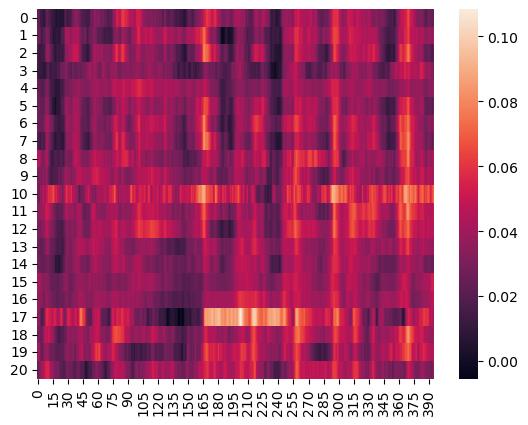

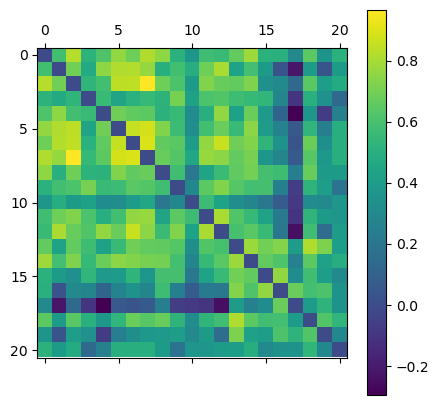

# original edges: 441  # preserved edges: 155
# node: 21  # edges: 155


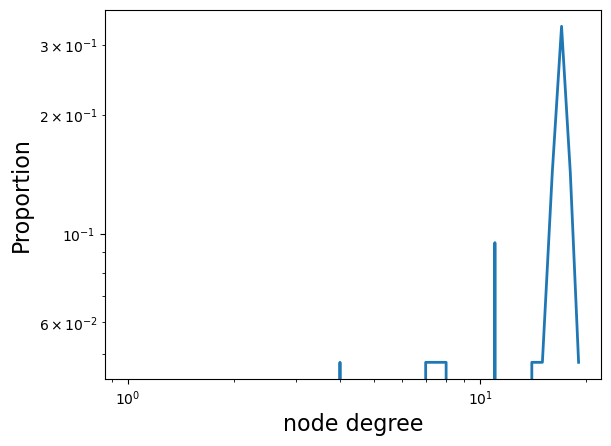

END


In [9]:
focus_regions = []
## Some brain regions of the specified flies are not used
if data_index in ["20230429-r5HT1.0-fly1", "20230516-r5HT1.0-fly4"]:
    focus_regions = focus_regions_1
elif data_index in ["20230601-r5HT1.0-fly3", "20230517-r5HT1.0-fly1"]:
    focus_regions = focus_regions_2
elif data_index == "20230601-r5HT1.0-fly1":
    focus_regions = focus_regions_3
else:
    focus_regions = focus_regions_0

'''
average neuron recordings for each region
'''
region_records_avg = []
for region_idx in focus_regions:
    print("---- processing region ", region_idx, " ----")

    ## load record data
    records = np.load(path_output +'neuron_concat_records/region_' + str(region_idx) + '_neuron_records.npy',allow_pickle=True)
    print("G7f data:", len(records), len(records[0]))
    
    ## select records for the given time period
    len_max = len(records[0])
    select_data = records[:, 4 : len_max - 4]
    print("selected data:", len(select_data), len(select_data[0]))
    
    ## generate average records
    select_data_avg = np.mean(select_data, axis = 0)
    region_records_avg.append(select_data_avg)
    
## plot average records
figure = plt.figure(figsize=(5,5))
data = pd.DataFrame(region_records_avg)
sns.heatmap(data)
plt.savefig(path_output + 'network/whole_brain_all_regions_records.png', dpi = 300, bbox_inches='tight')
plt.show()

'''
generate functional connectivity matrix
'''

## calculate pearson correlation matrix
data_list = []
n_neurons = len(region_records_avg)
similarity = np.zeros((n_neurons, n_neurons))
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):   
        pearson = pearsonr(region_records_avg[i], region_records_avg[j])
        similarity[i][j] = similarity[j][i] = pearson[0]
similarity = np.nan_to_num(similarity)
np.save(path_output + 'network/whole_brain_all_regions_similarity.npy', similarity)

## plot correlation matrix
figure = plt.figure(figsize=(5,5)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest') 
figure.colorbar(caxes) 
plt.savefig(path_output + 'network/whole_brain_all_regions_similarity.png', dpi = 300, bbox_inches='tight')
plt.show()

'''
generate functional connectivity network
'''

## keep only correlations with high positive values 
delete_seg = 0
weighted_edges_list = similarity.flatten()
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
nodes = [i for i in range(len(focus_regions_0)) if focus_regions_0[i] in focus_regions]
weighted_edges = [] 
source = []
target = []
weight = []
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):
        x, y = nodes[i], nodes[j]
        v = similarity[i,j]
        if v < threshold:
            continue
        weighted_edges.append(np.array([x, y, np.round(v,4)]))
        source.append(x)
        target.append(y)
        weight.append(np.round(v,4))
print("# original edges:", len(weighted_edges_list), " # preserved edges:", len(weighted_edges))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(path_output + 'network/regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '.csv', index=False)

'''
calculate network statistics
'''

## generate network
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(weighted_edges)

## network statistics
n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
print("# node:",n_nodes, " # edges:", n_edges)
degrees = nx.degree_histogram(G)
x = range(len(degrees))
y = [z / float(sum(degrees)) for z in degrees]
plt.loglog(x,y, linewidth = 2)
plt.xlabel("node degree", fontdict={'size': 16})
plt.ylabel("Proportion", fontdict={'size': 16})
plt.show()

degree_assortativity = nx.degree_assortativity_coefficient(G)
avg_clustering = nx.average_clustering(G)
avg_shortest_path = 0
diameter = 0
try:
    avg_shortest_path = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
except:
    print('G is not connected!')
density = nx.density(G)
transitivity = nx.transitivity(G)
d = dict(nx.degree(G))
avg_degree = sum(d.values())/G.number_of_nodes()

node_degrees = [round(i[1],3) for i in nx.degree(G,weight="weight")]
node_degrees_avg = np.mean(node_degrees)

degree_centrality = [round(i,3) for i in nx.degree_centrality(G).values()]
degree_centrality_avg = np.mean(degree_centrality)

closeness_centrality = [round(i,3) for i in nx.closeness_centrality(G).values()]
closeness_centrality_avg = np.mean(closeness_centrality)

betweenness_centrality = [round(i,3) for i in nx.betweenness_centrality(G).values()]
betweenness_centrality_avg = np.mean(betweenness_centrality)

louvain_communities_comm = community.louvain_communities(G, weight='weight')  
louvain_communities_mod = community.modularity(G, louvain_communities_comm)

greedy_modularity_communities_comm = community.greedy_modularity_communities(G, weight='weight')  
greedy_modularity_communities_mod = community.modularity(G, greedy_modularity_communities_comm)

# save network statistics into csv files 
writer = pd.ExcelWriter(path_output +'network_stat/regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '_stat.xlsx')  
data_dict = {}
data_dict["stats"] = ["nodes", "edges", "degree_assortativity", "avg_clustering", "avg_shortest_path", "density", "diameter", 
                      "transitivity", "avg_degree","n_degrees_mean", "n_degrees_mean_avg", "n_avg_degree_centrality", 
                      "n_avg_closeness_centrality", "n_avg_betweenness_centrality","n_degrees", "n_degree_centrality", 
                      "n_closeness_centrality",  "n_betweenness_centrality", "louvain_modulairty", "greedy_modularity"]
data_dict["values"] = [n_nodes, n_edges, round(degree_assortativity,3),round(avg_clustering,3),round(avg_shortest_path,3), round(density,3),
                    diameter, round(transitivity,3), round(avg_degree,3),
                    node_degrees_avg, round(node_degrees_avg/n_nodes,3), degree_centrality_avg,
                    closeness_centrality_avg, betweenness_centrality_avg, 
                    node_degrees, degree_centrality, closeness_centrality, betweenness_centrality,
                    louvain_communities_mod, greedy_modularity_communities_mod]
df = pd.DataFrame(data_dict)
df.to_excel(writer, sheet_name = "stat", index = False)        
writer.save()

print("END")

## Generate the functional connectivity network for each region

---- processing region  85  ----
G7f data: 410 404
selected data: 410 396


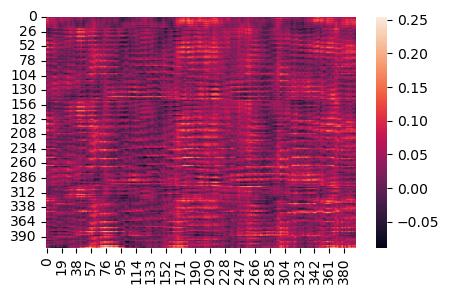

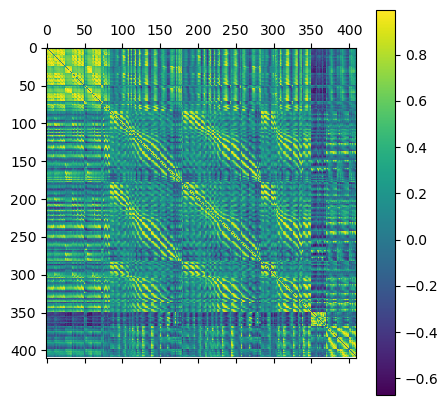

Successfully saving similarity matrix!
# original edges: 83845  # preserved edges: 33538
# node: 410  # edges: 33538
END


In [10]:
focus_regions = []
## Attention: Some brain regions of specified flies are not used.
if data_index in ["20230429-r5HT1.0-fly1", "20230516-r5HT1.0-fly4"]:
    focus_regions = focus_regions_1
elif data_index in ["20230601-r5HT1.0-fly3", "20230517-r5HT1.0-fly1"]:
    focus_regions = focus_regions_2
elif data_index == "20230601-r5HT1.0-fly1":
    focus_regions = focus_regions_3
else:
    focus_regions = focus_regions_0

## generate network for each region
for region_idx in [64,65,66,73,63,84,59,23,26,55,85,79,77]:   
    print("---- processing region ", region_idx, " ----")
    
    if region_idx not in focus_regions:
        continue
    
    '''
    load data
    '''
    
    ## load G7f data
    records = np.load(path_output + 'neuron_concat_records/region_' + str(region_idx) + '_neuron_records.npy',allow_pickle=True)
    print("G7f data:", len(records), len(records[0]))
    
    ## select records for the given time period
    len_max = len(records[0])
    select_data = records[:, 4 : len_max - 4]
    print("selected data:", len(select_data), len(select_data[0]))
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_records.npy', select_data)
       
    ## plot selected data
    figure = plt.figure(figsize=(5,3)) 
    data = pd.DataFrame(select_data)
    sns.heatmap(data)
    plt.savefig(path_output + 'network/region_' + str(region_idx) + '_all_neurons_records.png', dpi = 300, bbox_inches='tight')
    plt.show()
    
    '''
    generate functional connectivity matrix
    '''
    
    ## calculate pearson correlation
    region_similarity_dict = {}
    n_neurons = len(select_data)
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):   
            pearson = pearsonr(select_data[i], select_data[j])
            region_similarity_dict[(i,j)] = pearson[0]         
    
    ## calculate hierarchy clustering
    Z = linkage(select_data, 'ward') 
    k = 4
    clusters = fcluster(Z, k, criterion='maxclust')
    list(enumerate(clusters))
    hierarchy_idx = []
    for index_id in range(1,k+1):
        index = [i for i,j in enumerate(clusters) if j == index_id]
        hierarchy_idx.append(index)   
    hierarchy_idx_list = list(chain(*hierarchy_idx))
    
    ## calculate hierarchy correlation
    similarity = np.zeros((n_neurons, n_neurons))
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):   
            pair = (hierarchy_idx_list[i],hierarchy_idx_list[j])
            if pair not in region_similarity_dict.keys():
                pair = (hierarchy_idx_list[j],hierarchy_idx_list[i])
            similarity[i,j] = similarity[j,i] = np.mean(region_similarity_dict[pair])
            
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.savefig(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy.png',  dpi = 300, bbox_inches='tight')
    plt.show()
    
    ## save hierarchy correlation
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy_idpart.npy', hierarchy_idx)
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy_ids.npy', hierarchy_idx_list)
    np.save(path_output + 'network/region_' + str(region_idx) + '_all_neurons_similarity_hierarchy.npy', similarity)
    print("Successfully saving similarity matrix!")
        
    '''
    generate functional connectivity network
    '''
    
    ## keep only correlations with high positive values 
    delete_seg = 0.6
    weighted_edges_list = []
    for k,v in region_similarity_dict.items():
        weighted_edges_list.append(v)
    weighted_edges_list.sort()
    threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

    ## generate network from correlation matrix
    weighted_edges = [] 
    source = []
    target = []
    weight = []
    nodes = [i for i in range(n_neurons)]
    for k,v in region_similarity_dict.items():
        if v < threshold:
            continue
        weighted_edges.append(np.array([int(k[0]), int(k[1]), np.round(v,4)]))
        source.append(int(k[0]))
        target.append(int(k[1]))
        weight.append(np.round(v,4))
    print("# original edges:", len(region_similarity_dict), " # preserved edges:", len(weighted_edges))

    ## save network into csv files
    save_data_calc = {"source": source, "target": target, "weight": weight}
    df = pd.DataFrame(save_data_calc)
    df.to_csv(path_output + 'network/region_' + str(region_idx) + '_network.csv', index=False)

    
    '''
    calculate network statistics
    '''
    
    ## generate network
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)

    ## network stats
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("# node:",n_nodes, " # edges:", n_edges)
    
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    avg_clustering = nx.average_clustering(G)
    avg_shortest_path = 0
    try:
        avg_shortest_path = nx.average_shortest_path_length(G)
    except:
        print('G is not connected!')
    d = dict(nx.degree(G))
    avg_degree = sum(d.values())/G.number_of_nodes()
    
    node_degrees = [round(i[1],3) for i in nx.degree(G,weight="weight")]
    node_degrees_avg = np.mean(node_degrees)
    node_degrees.sort(reverse = True)

    degree_centrality = [round(i,3) for i in nx.degree_centrality(G).values()]
    degree_centrality_avg = np.mean(degree_centrality)
    degree_centrality.sort(reverse = True)

    closeness_centrality = [round(i,3) for i in nx.closeness_centrality(G).values()]
    closeness_centrality_avg = np.mean(closeness_centrality)
    closeness_centrality.sort(reverse = True)
    
    ## save network statistics into csv files
    writer = pd.ExcelWriter(path_output + 'network_stat/region_' + str(region_idx) + '_network_stat.xlsx')
    data_dict = {}
    data_dict["stats"] = ["nodes", "edges", "degree_assortativity", "avg_clustering", "avg_shortest_path", "avg_degree",
                        "n_degrees_mean", "n_avg_degree_centrality", "n_avg_closeness_centrality", "n_degrees", 
                        "n_degree_centrality", "n_closeness_centrality"]
    data_dict["values"] = [n_nodes, n_edges, round(degree_assortativity,3), round(avg_clustering,3), round(avg_shortest_path,3),
                 round(avg_degree,3), node_degrees_avg, degree_centrality_avg, closeness_centrality_avg, node_degrees, 
                 degree_centrality, closeness_centrality]

    df = pd.DataFrame(data_dict)
    df.to_excel(writer, sheet_name = "stat", index = False)        
    writer.save()
    
print("END")